## Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

## Let's import data from google drive

### You can find the zip file in [link](https://drive.google.com/file/d/1kCosTCBz4ArgNQS2hnq1zASCFFccW00V/view?usp=share_link)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/Shared FIles/task_2.zip'
!cp '{file_path}' .

## Let's unzip task_2.zip file

In [ ]:
!unzip task_2.zip
!rm task_2.zip -rf
!unzip train.zip
!rm train.zip -rf
!unzip test.zip
!rm test.zip -rf
!mv content/test .
!rm content -rf

# now we should have test and train folder, with lots of images

After above code your directory structure should be like this:
```bash
/
├── fingerprint_recognition.ipynb
├── test/
│   ├── image_1.jpg
│   ├── image_2.jpg
│   ├── ...
│   └── image_n.jpg
└── train/
    ├── image_1.jpg
    ├── image_2.jpg
    ├── ...
    └── image_n.jpg
```

## Distribute images according to their labels to different files

Needed from image_dataset_from_directory()

In [7]:
import shutil

def import_files(dir='train'):
  if dir != 'train' and dir != 'test':
    print('W:import_files(dir): dir should be either train or test')
    return

  root = 'data'
  if not os.path.exists(root):
    os.makedirs(root)
  new_train = f'data/{dir}'
  for filename in os.listdir(dir):
    id, target = filename.split('_')
    target = int(target.split('.')[0])

    dir_path = f'{new_train}/{target}'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)

    bmp = filename.endswith('.bmp')
    src_file = f'{dir}/{filename}'
    dest_file = f'{dir_path}/{filename}' + ('' if bmp else '.bmp')

    shutil.copy(src_file, dest_file)


### Import train and test files

In [8]:
import_files('train')
import_files('test')

After distribution you should have directory structure like this:
```bash
/
├── fingerprint_recognition.ipynb
└── data/
    ├── train/
    │   ├── 0/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 1/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 2/
    │   ├── ...
    │   └── 9/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    ├── test/
    │   ├── 0/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 1/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    │   ├── 2/
    │   ├── ...
    │   └── 9/
    │   │   ├── image_1.jpg
    │   │   ├── ...
    │   │   └── image_n.jpg
    └── ...
```

## Let see if we have balanced dataset

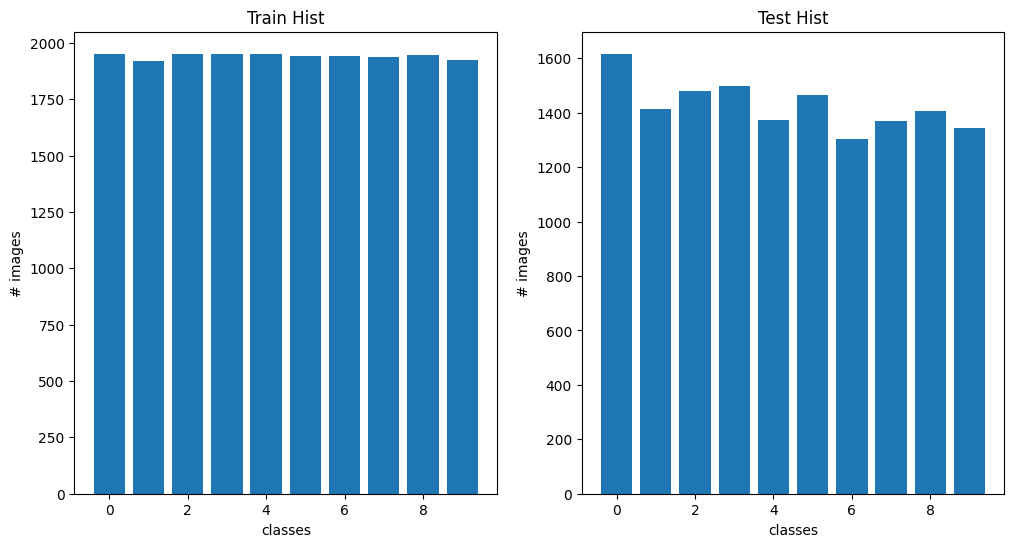

In [9]:
def plot_hist_classes(dir):

  n_samples = np.zeros(10)
  for class_dir in os.listdir(dir):
    if not os.path.isdir(os.path.join(dir, class_dir)):
      print('E:plot_hist_classes(dir): expected to find in `dir` only directories')
      return
    num_files = len([f for f in os.listdir(os.path.join(dir, class_dir))])

    n_samples[int(class_dir)] = num_files

  plt.bar(range(len(n_samples)), n_samples)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Hist')
plt.xlabel('classes')
plt.ylabel('# images')
plot_hist_classes('data/train')

plt.subplot(1, 2, 2)
plt.title('Test Hist')
plt.xlabel('classes')
plt.ylabel('# images')
plot_hist_classes('data/test')
plt.show()

### Okay, our dataset is more or less balanced, which is good

## Create train and test Datasets

In [4]:
batch_size = 512
img_size = (100, 100)

train_dir = 'data/train'
train_dataset, val_dataset = image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.2,
    subset='both',
    seed=123,
)

test_dir = 'data/test'
test_dataset = image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
)


Found 19413 files belonging to 10 classes.
Using 15531 files for training.
Using 3882 files for validation.
Found 14272 files belonging to 10 classes.


## Create preprocessing layer

In [5]:
preprocessing = keras.Sequential([
    layers.RandomBrightness(0.2),
    layers.RandomRotation(0.2),
    layers.Rescaling(1./255),
])

classes = 10

## Define the model architecture

[This](https://arxiv.org/pdf/1409.1556.pdf) research paper provides good architerture for IMAGE RECOGNITION.



In [15]:
model = keras.Sequential([
  preprocessing,

  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
  
  layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2, 2) ,strides=(2, 2)),

  layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
  layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(classes, activation='softmax'),
])

In [16]:
model.build((None, img_size[0], img_size[1], 3))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 256)      

## Compile the model

In [18]:
learning_rate = 0.001
epochs = 1024

optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
loss = keras.losses.sparse_categorical_crossentropy
metrics=['accuracy']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

## Create Callbacks


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = keras.callbacks.ModelCheckpoint(
    "vgg13_4.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)


early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto'
)

## Fit the model

In [21]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=[checkpoint, early],
    use_multiprocessing=True,
    workers=2,
)

Epoch 1/1024
31/31 [==============================] - ETA: 0s - loss: 2.2796 - accuracy: 0.1297
Epoch 1: val_loss improved from inf to 2.09699, saving model to vgg13_4.h5
31/31 [==============================] - 19s 459ms/step - loss: 2.2796 - accuracy: 0.1297 - val_loss: 2.0970 - val_accuracy: 0.1960
Epoch 2/1024
31/31 [==============================] - ETA: 0s - loss: 2.0892 - accuracy: 0.2203
Epoch 2: val_loss did not improve from 2.09699
31/31 [==============================] - 14s 414ms/step - loss: 2.0892 - accuracy: 0.2203 - val_loss: 2.2830 - val_accuracy: 0.2020
Epoch 3/1024
31/31 [==============================] - ETA: 0s - loss: 1.9945 - accuracy: 0.2686
Epoch 3: val_loss improved from 2.09699 to 1.81019, saving model to vgg13_4.h5
31/31 [==============================] - 15s 446ms/step - loss: 1.9945 - accuracy: 0.2686 - val_loss: 1.8102 - val_accuracy: 0.3207
Epoch 4/1024
31/31 [==============================] - ETA: 0s - loss: 1.8676 - accuracy: 0.3110
Epoch 4: val_loss d

## Let's visualize the results

### Plot loss

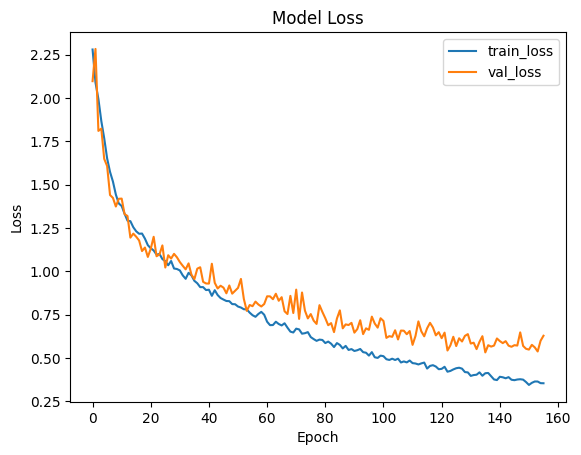

In [22]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Plot accuracy

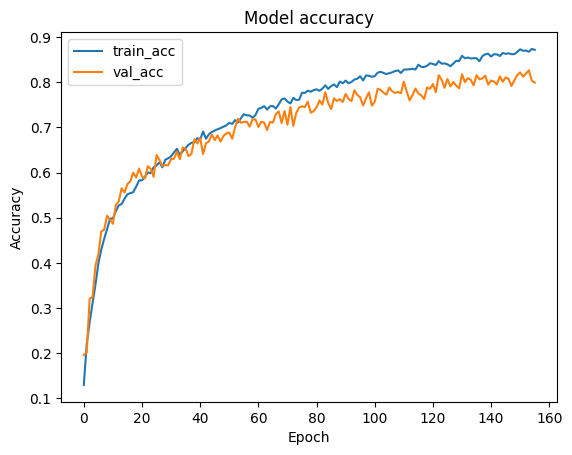

In [23]:
plt.plot(history.history["accuracy"], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Evaluate Test dataset

In [24]:
model.evaluate(
    test_dataset,
    batch_size=batch_size,
    use_multiprocessing=True,
    workers=2,
)

28/28 [==============================] - 9s 194ms/step - loss: 0.9434 - accuracy: 0.7143


[0.9434304237365723, 0.7142657041549683]